In [1]:
# !pip install xgboost
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, RFE, SelectFromModel, SelectKBest, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, make_scorer, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product


In [2]:
X = pd.read_csv('data/x_train.txt', sep=' ', header=None)
y = pd.read_csv('data/y_train.txt', sep=' ', header=None)

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


 Feature selection

/Users/mikolaj/code/aml/Advanced-ML-High-Accuracy-Parsimonious-Model/.venv/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[0.01438222 0.01058839 0.03672075 0.01357297 0.01359942 0.01215094
 0.03036258 0.01487964 0.01437406 0.00743115 0.00167065 0.00157289
 0.00171386 0.00157415 0.00168428 0.00150812 0.0016351  0.00206298
 0.00162288 0.00197922 0.00162693 0.00151431 0.00136646 0.00126127
 0.00189355 0.00148392 0.00158783 0.00167692 0.00216564 0.00128766
 0.0014548  0.00140302 0.00198179 0.00169624 0.00182983 0.00155979
 0.00161107 0.00115246 0.00196835 0.00132662 0.00160414 0.0019867
 0.00144898 0.00141004 0.00174492 0.00150754 0.0018096  0.00178421
 0.00194977 0.0018667  0.00168885 0.00209288 0.00183871 0.0014122
 0.00168748 0.00161297 0.00158726 0.00145208 0.00161414 0.0015378
 0.00141956 0.00169047 0.00159186 0.00160845 0.00160586 0.00158568
 0.00173297 0.00129136 0.00136306 0.00154021 0.00181192 0.00174877
 0.00161971 0.001411   0.00153455 0.00193374 0.00154727 0.00130056
 0.00147971 0.00156089 0.00151558 0.00218189 0.00164422 0.00156471
 0.00120762 0.00169749 0.00168776 0.00169532 0.00161316 0.0013065

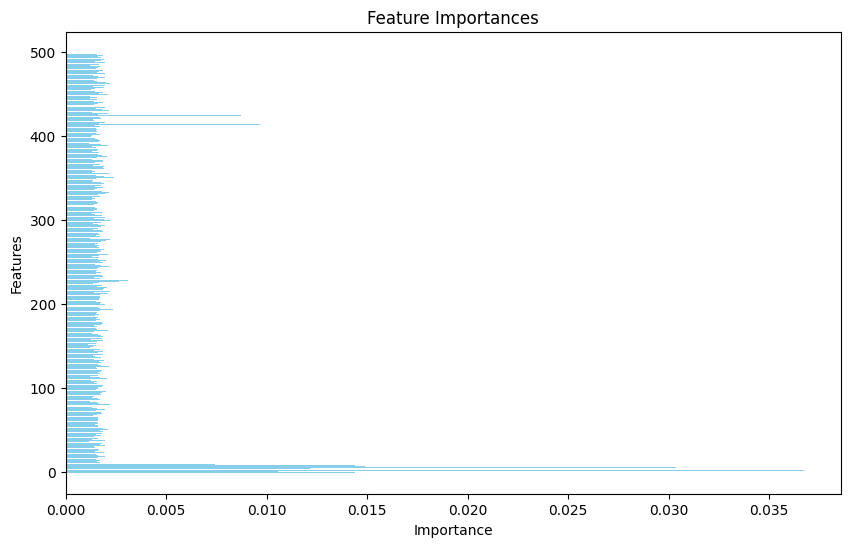

In [3]:
columns = range(0,500)
# EMBEDDED: ( Random Forest )
rf = RandomForestClassifier()
rf.fit(X, y)
importances = rf.feature_importances_
print(importances)
importances_sorted_indices = np.argsort(importances)[::-1]
feature_names_sorted = [columns[i] for i in importances_sorted_indices]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(feature_names_sorted, importances[importances_sorted_indices], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()




In [4]:
threshold = [0.002, 0.003, 0.005, 0.007]
selected_features = []
for t in threshold:
    rf_selected = [columns[i] for i in range(len(columns)) if importances[i] > t]
    print(f'Features above importance of {t}: {rf_selected}')
    print('Number of features: ', len(rf_selected))
    selected_features.append(rf_selected)


Features above importance of 0.002: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 17, 28, 51, 81, 96, 112, 126, 169, 194, 213, 215, 220, 227, 228, 245, 252, 259, 260, 276, 277, 286, 298, 300, 332, 333, 351, 356, 367, 376, 385, 389, 404, 414, 424, 425, 427, 431, 436, 450, 462, 463, 474, 492]
Number of features:  53
Features above importance of 0.003: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 228, 414, 425, 462]
Number of features:  14
Features above importance of 0.005: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 414, 425, 462]
Number of features:  13
Features above importance of 0.007: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 414, 425, 462]
Number of features:  13


In [5]:
class MyAdaBoost(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, depth=1, n_estimators=50):
        self.base_estimator = base_estimator
        self.depth = depth
        self.n_estimators = n_estimators
        self.models = []
        self.betas = []

        if self.base_estimator is None:
            self.base_estimator = DecisionTreeClassifier(max_depth=self.depth)

    def fit(self, X, y):
        y = np.ravel(y)  # guarantees 1D NumPy array
        n = X.shape[0]
        w = np.ones(n) / n

        for _ in range(self.n_estimators):
            model = clone(self.base_estimator)
            model.fit(X, y, sample_weight=w)
            y_pred = model.predict(X)

            miss = (y_pred != y)
            err = np.dot(w, miss)

            beta = err / (1 - err)

            self.models.append(model)
            self.betas.append(beta)

            w *= np.where(miss, 1, beta)
            w /= np.sum(w)
            
    def predict(self, X):
        classes = np.unique(self.models[0].predict(X))
        votes = np.zeros((X.shape[0], len(classes)))

        for model, beta in zip(self.models, self.betas):
            preds = model.predict(X)
            for i, c in enumerate(classes):
                votes[:, i] += (preds == c) * np.log(1 / beta)

        return classes[np.argmax(votes, axis=1)]
    
    def get_params(self, deep=True):
        return {
            "base_estimator": self.base_estimator,
            "depth": self.depth,
            "n_estimators": self.n_estimators
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        if "depth" in params:
            self.base_estimator = DecisionTreeClassifier(max_depth=params["depth"])
        return self


In [ ]:

def custom_score(y_true, y_pred, n_features_used):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    accuracy = accuracy_score(y_true, y_pred)
    score = 10 * tp - 200 * n_features_used
    return score, accuracy


def model_search(X, y, models_with_params, feature_selectors, cv=4):
    X = X.to_numpy() if isinstance(X, pd.DataFrame) else np.asarray(X)
    y = np.asarray(y).ravel()

    best_score = -np.inf
    best_model = None
    best_features = None
    results = []

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    for selector_name, selector in feature_selectors.items():
        fold_scores = []
        fold_accuracies = []
        
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Handle SelectFromModel with percentile thresholds
            if "SelectFromModel" in selector_name and "percentile" in selector_name:
                # Extract percentile from selector name
                percentile = float(selector_name.split("=")[1].replace("th_percentile", ""))
                
                # Fit RF on training fold only
                temp_rf = RandomForestClassifier(n_estimators=70, random_state=42)
                temp_rf.fit(X_train, y_train)
                
                # Compute threshold from training data only
                importances = temp_rf.feature_importances_
                threshold = np.percentile(importances, percentile)
                
                # Create selector with computed threshold
                fold_selector = SelectFromModel(estimator=temp_rf, threshold=threshold, prefit=True)
                selected_mask = fold_selector.get_support()
            else:
                # For other selectors (like SelectKBest), fit normally
                from sklearn.base import clone
                fold_selector = clone(selector)
                fold_selector.fit(X_train, y_train)
                selected_mask = fold_selector.get_support()
            
            X_train_sel = X_train[:, selected_mask]
            X_test_sel = X_test[:, selected_mask]
            n_features = np.sum(selected_mask)
            
            # Try each model configuration
            for model_name, (model, param_grid) in models_with_params.items():
                for params in param_grid:
                    model.set_params(**params)
                    
                    clf = clone(model)
                    clf.fit(X_train_sel, y_train)
                    y_pred = clf.predict(X_test_sel)
                    
                    score, accuracy = custom_score(y_test, y_pred, n_features)
                    fold_scores.append(score)
                    fold_accuracies.append(accuracy)
        
        # Average across folds for this selector/model combination
        for model_name, (model, param_grid) in models_with_params.items():
            for i, params in enumerate(param_grid):
                # Get scores for this specific model config
                start_idx = i * cv
                end_idx = start_idx + cv
                model_fold_scores = fold_scores[start_idx:end_idx] if len(fold_scores) > start_idx else []
                model_fold_accuracies = fold_accuracies[start_idx:end_idx] if len(fold_accuracies) > start_idx else []
                
                if model_fold_scores:  # Only if we have scores
                    avg_score = np.mean(model_fold_scores)
                    avg_accuracy = np.mean(model_fold_accuracies)
                    
                    # For final model fitting, handle feature selection
                    if "SelectFromModel" in selector_name and "percentile" in selector_name:
                        percentile = float(selector_name.split("=")[1].replace("th_percentile", ""))
                        final_rf = RandomForestClassifier(n_estimators=70, random_state=42)
                        final_rf.fit(X, y)
                        final_threshold = np.percentile(final_rf.feature_importances_, percentile)
                        final_selector = SelectFromModel(estimator=final_rf, threshold=final_threshold, prefit=True)
                        final_mask = final_selector.get_support()
                        n_features = np.sum(final_mask)
                    else:
                        final_selector = clone(selector)
                        final_selector.fit(X, y)
                        final_mask = final_selector.get_support()
                        n_features = np.sum(final_mask)
                    
                    results.append((avg_score, avg_accuracy, model_name, params, selector_name, n_features))
                    
                    if avg_score > best_score:
                        best_score = avg_score
                        best_accuracy = avg_accuracy
                        X_sel = X[:, final_mask]
                        best_model = clone(model).set_params(**params).fit(X_sel, y)
                        best_features = np.where(final_mask)[0]

    return best_model, best_features, best_score, best_accuracy, results


In [ ]:

C_vals = [0.01, 0.1, 1.0]
penalties = ['l1', 'l2']

n_estimators = [400, 500]
max_depth = [None, 3, 5]


models_with_params = {
    "LogisticRegression": (
        LogisticRegression(solver='liblinear', max_iter=500),  # 'liblinear' supports both l1 and l2
    [
        {"C": c, "penalty": p}
        for c, p in product(C_vals, penalties)
    ])

}


k_values = [2, 3, 4, 5, 6, 7, 8]

def build_selectors():
    selectors = {}

    # SelectKBest with k values
    for k in k_values:
        selectors[f"SelectKBest_k={k}"] = SelectKBest(score_func=mutual_info_classif, k=k)


    # Use percentile-based thresholds
    for p in [98.5, 99, 99.2, 99.5, 99.7]:
        base_rf = RandomForestClassifier(n_estimators=70, random_state=42)
        threshold = p/100
        label = f"{p}th_percentile"
        selectors[f"SelectFromModel_thresh={label}"] = SelectFromModel(estimator=base_rf, threshold=threshold, prefit=False)

    return selectors


feature_selectors = build_selectors()
best_lr, best_lr_features, best_lr_score, best_lr_accuracy, all_lr_results = model_search(X, y, models_with_params, feature_selectors)

df_results_lr = pd.DataFrame(all_lr_results, columns=["Score", "Accuracy", "Model", "Params", "Feature_Selector", "Num_Features"])
df_results_lr.sort_values(by="Score", ascending=False).head(50)



,Score,Accuracy,Model,Params,Feature_Selector,Num_Features
0,3782.5,0.7170,LogisticRegression,"{'C': 0.01, 'penalty': 'l1'}",SelectKBest_k=2,2
66,3780.0,0.7168,LogisticRegression,"{'C': 0.01, 'penalty': 'l1'}",SelectFromModel_thresh=99.7th_percentile,2
69,3757.5,0.7050,LogisticRegression,"{'C': 0.1, 'penalty': 'l2'}",SelectFromModel_thresh=99.7th_percentile,2
3,3730.0,0.7006,LogisticRegression,"{'C': 0.1, 'penalty': 'l2'}",SelectKBest_k=2,2
67,3650.0,0.7066,LogisticRegression,"{'C': 0.01, 'penalty': 'l2'}",SelectFromModel_thresh=99.7th_percentile,2
1,3645.0,0.7076,LogisticRegression,"{'C': 0.01, 'penalty': 'l2'}",SelectKBest_k=2,2
70,3627.5,0.7008,LogisticRegression,"{'C': 1.0, 'penalty': 'l1'}",SelectFromModel_thresh=99.7th_percentile,2
4,3622.5,0.6994,LogisticRegression,"{'C': 1.0, 'penalty': 'l1'}",SelectKBest_k=2,2
6,3615.0,0.7196,LogisticRegression,"{'C': 0.01, 'penalty': 'l1'}",SelectKBest_k=3,3
60,3615.0,0.7196,LogisticRegression,"{'C': 0.01, 'penalty': 'l1'}",SelectFromModel_thresh=99.5th_percentile,3


In [8]:


n_estimators = [400, 500]
max_depth = [None, 3, 5]


models_with_params = {

    "RandomForest": (
        RandomForestClassifier(),
        [{"n_estimators": n, "max_depth": d}
            for n, d in product(n_estimators, max_depth)]
    )
}


best_rf, best_rf_features, best_rf_score, best_rf_accuracy, all_rf_results = model_search(X, y, models_with_params, feature_selectors)

df_results_rf = pd.DataFrame(all_rf_results, columns=["Score", "Accuracy", "Model", "Params", "Feature_Selector", "Num_Features"])
df_results_rf.sort_values(by="Score", ascending=False).head(50)


,Score,Accuracy,Model,Params,Feature_Selector,Num_Features
0,3835.0,0.6864,RandomForest,"{'n_estimators': 400, 'max_depth': None}",SelectKBest_k=2,2
66,3827.5,0.6860,RandomForest,"{'n_estimators': 400, 'max_depth': None}",SelectFromModel_thresh=99.7th_percentile,2
3,3805.0,0.6812,RandomForest,"{'n_estimators': 500, 'max_depth': None}",SelectKBest_k=2,2
1,3805.0,0.7032,RandomForest,"{'n_estimators': 400, 'max_depth': 3}",SelectKBest_k=2,2
6,3780.0,0.7116,RandomForest,"{'n_estimators': 400, 'max_depth': None}",SelectKBest_k=3,3
60,3770.0,0.7112,RandomForest,"{'n_estimators': 400, 'max_depth': None}",SelectFromModel_thresh=99.5th_percentile,3
67,3752.5,0.6938,RandomForest,"{'n_estimators': 400, 'max_depth': 3}",SelectFromModel_thresh=99.7th_percentile,2
69,3742.5,0.6810,RandomForest,"{'n_estimators': 500, 'max_depth': None}",SelectFromModel_thresh=99.7th_percentile,2
70,3710.0,0.6864,RandomForest,"{'n_estimators': 500, 'max_depth': 3}",SelectFromModel_thresh=99.7th_percentile,2
2,3690.0,0.7068,RandomForest,"{'n_estimators': 400, 'max_depth': 5}",SelectKBest_k=2,2


In [9]:


n_estimators = [400, 500]
max_depth = [None, 3, 5]


models_with_params = {

    "AdaBoost": ( MyAdaBoost(), 
    [{"n_estimators": n, "max_depth": d}
            for n, d in product(n_estimators, max_depth)]
    )
}


best_ab, best_ab_features, best_ab_score, best_ab_accuracy, all_ab_results = model_search(X, y, models_with_params, feature_selectors)

df_results_ab = pd.DataFrame(all_ab_results, columns=["Score", "Accuracy", "Model", "Params", "Feature_Selector", "Num_Features"])
df_results_ab.sort_values(by="Score", ascending=False).head(50)


,Score,Accuracy,Model,Params,Feature_Selector,Num_Features
0,4062.5,0.7148,AdaBoost,"{'n_estimators': 400, 'max_depth': None}",SelectKBest_k=2,2
66,4062.5,0.7148,AdaBoost,"{'n_estimators': 400, 'max_depth': None}",SelectFromModel_thresh=99.7th_percentile,2
3,3990.0,0.7040,AdaBoost,"{'n_estimators': 500, 'max_depth': None}",SelectKBest_k=2,2
69,3990.0,0.7040,AdaBoost,"{'n_estimators': 500, 'max_depth': None}",SelectFromModel_thresh=99.7th_percentile,2
1,3985.0,0.7132,AdaBoost,"{'n_estimators': 400, 'max_depth': 3}",SelectKBest_k=2,2
67,3985.0,0.7132,AdaBoost,"{'n_estimators': 400, 'max_depth': 3}",SelectFromModel_thresh=99.7th_percentile,2
2,3900.0,0.7128,AdaBoost,"{'n_estimators': 400, 'max_depth': 5}",SelectKBest_k=2,2
68,3900.0,0.7128,AdaBoost,"{'n_estimators': 400, 'max_depth': 5}",SelectFromModel_thresh=99.7th_percentile,2
6,3862.5,0.7150,AdaBoost,"{'n_estimators': 400, 'max_depth': None}",SelectKBest_k=3,3
60,3862.5,0.7150,AdaBoost,"{'n_estimators': 400, 'max_depth': None}",SelectFromModel_thresh=99.5th_percentile,3


In [10]:


n_estimators = [400, 500]
max_depth = [None, 3, 5]


models_with_params = {

    "GradientBoostingClassifier": (
        GradientBoostingClassifier(),
        [{"n_estimators": n, "max_depth": d}
             for n, d in product(n_estimators, max_depth)]
    )
}


best_gb, best_gb_features, best_gb_score, best_gb_accuracy, all_gb_results = model_search(X, y, models_with_params, feature_selectors)

df_results_gb = pd.DataFrame(all_gb_results, columns=["Score", "Accuracy", "Model", "Params", "Feature_Selector", "Num_Features"])
df_results_gb.sort_values(by="Score", ascending=False).head(50)


,Score,Accuracy,Model,Params,Feature_Selector,Num_Features
1,3592.5,0.6676,GradientBoostingClassifier,"{'n_estimators': 400, 'max_depth': 3}",SelectKBest_k=2,2
67,3505.0,0.6530,GradientBoostingClassifier,"{'n_estimators': 400, 'max_depth': 3}",SelectFromModel_thresh=99.7th_percentile,2
0,3495.0,0.6392,GradientBoostingClassifier,"{'n_estimators': 400, 'max_depth': None}",SelectKBest_k=2,2
2,3495.0,0.6580,GradientBoostingClassifier,"{'n_estimators': 400, 'max_depth': 5}",SelectKBest_k=2,2
66,3495.0,0.6374,GradientBoostingClassifier,"{'n_estimators': 400, 'max_depth': None}",SelectFromModel_thresh=99.7th_percentile,2
4,3492.5,0.6480,GradientBoostingClassifier,"{'n_estimators': 500, 'max_depth': 3}",SelectKBest_k=2,2
3,3470.0,0.6366,GradientBoostingClassifier,"{'n_estimators': 500, 'max_depth': None}",SelectKBest_k=2,2
69,3467.5,0.6408,GradientBoostingClassifier,"{'n_estimators': 500, 'max_depth': None}",SelectFromModel_thresh=99.7th_percentile,2
70,3465.0,0.6490,GradientBoostingClassifier,"{'n_estimators': 500, 'max_depth': 3}",SelectFromModel_thresh=99.7th_percentile,2
61,3462.5,0.6718,GradientBoostingClassifier,"{'n_estimators': 400, 'max_depth': 3}",SelectFromModel_thresh=99.5th_percentile,3


In [ ]:


n_estimators = [300, 400, 500]
max_depth = [None, 3, 5]


models_with_params = {

    "BaggingClassifier": (
        BaggingClassifier(),
        [{"n_estimators": n}
             for n in n_estimators]
    )
}


best_bc, best_bc_features, best_bc_score, best_bc_accuracy, all_bc_results = model_search(X, y, models_with_params, feature_selectors)

df_results_bc = pd.DataFrame(all_bc_results, columns=["Score", "Accuracy", "Model", "Params", "Feature_Selector", "Num_Features"])
df_results_bc.sort_values(by="Score", ascending=False).head(50)


 We check the influence of the number of features on the score and accuracy

In [ ]:
df_results_num_features = pd.DataFrame(all_results, columns=["Score", "Accuracy", "Model", "Params", "Feature_Selector", "Num_Features"])
df_results_num_features.sort_values(by="Score", ascending=False).head(100)


 Compare performance of top models on same subsets of data

In [ ]:
def model_search_1(X, y, models_with_params, feature_selectors, test_size=0.3, random_state=42):
    X = X.to_numpy() if isinstance(X, pd.DataFrame) else np.asarray(X)
    y = np.asarray(y).ravel()

    best_score = -np.inf
    best_model = None
    best_features = None
    best_accuracy = None
    results = []

    # Use one consistent data split for all selector/model runs
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    for selector_name, selector in feature_selectors.items():
        # Handle SelectFromModel with percentile thresholds
        if "SelectFromModel" in selector_name and "percentile" in selector_name:
            # Extract percentile from selector name
            percentile = float(selector_name.split("=")[1].replace("th_percentile", ""))
            
            # Fit RF on training data only (no leakage)
            temp_rf = RandomForestClassifier(n_estimators=70, random_state=42)
            temp_rf.fit(X_train, y_train)
            
            # Compute threshold from training data only
            importances = temp_rf.feature_importances_
            threshold = np.percentile(importances, percentile)
            
            train_selector = SelectFromModel(estimator=temp_rf, threshold=threshold, prefit=True)
            selected_mask = train_selector.get_support()
        else:
            from sklearn.base import clone
            train_selector = clone(selector)
            train_selector.fit(X_train, y_train)
            selected_mask = train_selector.get_support()
        
        n_features = np.sum(selected_mask)

        # Apply mask to both sets
        X_train_sel = X_train[:, selected_mask]
        X_test_sel = X_test[:, selected_mask]

        for model_name, (model, param_grid) in models_with_params.items():
            for params in param_grid:
                model.set_params(**params)

                clf = clone(model)
                clf.fit(X_train_sel, y_train)
                y_pred = clf.predict(X_test_sel)

                score, accuracy = custom_score(y_test, y_pred, n_features)
                results.append((score, accuracy, model_name, params, selector_name, n_features))

                if score > best_score:
                    best_score = score
                    best_accuracy = accuracy
                    
                    # For final model, we need to recompute feature selection on full data
                    if "SelectFromModel" in selector_name and "percentile" in selector_name:
                        final_rf = RandomForestClassifier(n_estimators=70, random_state=42)
                        final_rf.fit(X, y)
                        final_importances = final_rf.feature_importances_
                        final_threshold = np.percentile(final_importances, percentile)
                        final_selector = SelectFromModel(estimator=final_rf, threshold=final_threshold, prefit=True)
                        final_mask = final_selector.get_support()
                    else:
                        # For other selectors, fit on full data
                        final_selector = clone(selector)
                        final_selector.fit(X, y)
                        final_mask = final_selector.get_support()
                    
                    # Train final model on full data with selected features
                    X_all_sel = X[:, final_mask]
                    best_model = clone(model).set_params(**params).fit(X_all_sel, y)
                    best_features = np.where(final_mask)[0]

    return best_model, best_features, best_score, best_accuracy, results

k_values = [2, 4, 6, 8]

def build_selectors_1():
    selectors = {}

    # SelectKBest with k values
    for k in k_values:
        selectors[f"SelectKBest_k={k}"] = SelectKBest(score_func=mutual_info_classif, k=k)

    # Use percentile-based thresholds
    for p in [99, 99.7]:
        base_rf = RandomForestClassifier(n_estimators=70, random_state=42)
        threshold = p / 100
        label = f"{p}th_percentile"
        selectors[f"SelectFromModel_thresh={label}"] = SelectFromModel(estimator=base_rf, threshold=threshold, prefit=False)

    return selectors


models_with_params_1 = {
    "LogisticRegression": (
        LogisticRegression(solver='liblinear', max_iter=500),  # 'liblinear' supports both l1 and l2
    [
        {"C": 0.1, "penalty": p}
        for p in ['l1', 'l2']
    ])
    ,
    "RandomForest": (
        RandomForestClassifier(),
        [{"n_estimators": n, "max_depth": d}
            for n, d in product([400, 500], [None, 3, 5])]
    ),
    "AdaBoost": ( MyAdaBoost(), 
    [{"n_estimators": n, "max_depth": d}
            for n, d in product([400, 500], [None, 3, 5])]
    ),
    "GradientBoostingClassifier": (
        GradientBoostingClassifier(),
        [{"n_estimators": n, "max_depth": d}
             for n, d in product([400, 500], [None, 3, 5])]
    ),
    "BaggingClassifier": (
        BaggingClassifier(),
        [{"n_estimators": n}
             for n in [400, 500]]
    )
}
feature_selectors_1 = build_selectors_1()
#print(feature_selectors)
best_model_1, best_features_1, best_score_1, best_accuracy_1, all_results_1 = model_search_1(X, y, models_with_params_1, feature_selectors_1)


df_results_1 = pd.DataFrame(all_results_1, columns=["Score", "Accuracy", "Model", "Params", "Feature_Selector", "Num_Features"])
df_results_1.sort_values(by="Score", ascending=False).head(100)


In [ ]:
df_results_total_1 = pd.DataFrame(all_results_1, columns=["Score", "Accuracy", "Model", "Params", "Feature_Selector", "Num_Features"])
df_results_total_1.sort_values(by="Accuracy", ascending=False).head(50)


 Take the variant: 4370	0.721333	RandomForest	{'n_estimators': 400, 'max_depth': 5}	SelectKBest_k=4	4

In [ ]:
X_final = pd.read_csv('data/x_test.txt', sep=' ', header=None)
X_final = scaler.transform(X_final)

X = X.to_numpy() if isinstance(X, pd.DataFrame) else np.asarray(X)
y = np.asarray(y).ravel()

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

selector = SelectKBest(score_func=mutual_info_classif, k=4)
selector.fit(X_train, y_train)
mask = selector.get_support()
selected_features = selector.get_support(indices=True)
n_features = mask.sum()

X_train_sel = X_train[:, mask]
X_test_sel  = X_test[:, mask]


print("Features selected")
model = RandomForestClassifier(n_estimators=400, max_depth=5)
model.fit(X_train_sel, y_train)
y_pred = model.predict(X_test_sel)
score, accuracy = custom_score(y_test, y_pred, n_features)
print(f"Score: {score}, accuracy: {accuracy}")

print("\nAll features ")
model = RandomForestClassifier(n_estimators=400, max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score, accuracy = custom_score(y_test, y_pred, 500)
print(f"Score: {score}, accuracy: {accuracy}")


In [ ]:
X_final = X_final.to_numpy() if isinstance(X_final, pd.DataFrame) else np.asarray(X_final)
X_final_sel  = X_final[:, mask]
X_sel = X[:, mask]

print(f"Final features selected: {n_features}")
model = RandomForestClassifier(n_estimators=400, max_depth=5)
model.fit(X_sel, y)
y_proba = model.predict_proba(X_final_sel)[:, 1]

# Select top 1000 indices
top_1000_indices = np.argsort(y_proba)[-1000:]  # ascending → take last 1000

np.savetxt("312889_obs.txt", top_1000_indices, fmt='%d')

# best_features should be a NumPy array of column indices
np.savetxt("312889_vars.txt", selected_features, fmt='%d')


